<a href="https://colab.research.google.com/github/czek0/Data-Science-Portfolio/blob/main/Covid19_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid19 Forecasting**
Data Loading and Preprocessing
In this step, we load the COVID-19 dataset from the provided URL using the pd.read_csv function from the pandas library. We parse the 'data' column as datetime objects and normalize the dates using the dt.normalize() method. Then, we group the data by date and sum the values to get the total daily data for Italy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import holidays


In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])
df['data'] = pd.to_datetime(df['data']).dt.normalize()
df_italy = df.groupby('data').sum()

<ipython-input-2-e187975450f7>:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])


### Preprocessing the data
Lets create a column to store the holiday data and check for null values

In [19]:
it_holidays = holidays.Italy()
df_italy['is_holiday'] = [1 if date in it_holidays else 0 for date in df_italy.index]



In [20]:
df.head()


,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
0,2020-02-24,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-24,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-24,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-24,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-24,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Checking for Stationarity
Before fitting a time series model, it's essential to check if the data is stationary. We define a function test_stationarity that plots the rolling mean and rolling standard deviation of the time series, and performs the Augmented Dickey-Fuller (ADF) test to check for stationarity.

In [21]:

# Function to test stationarity
def test_stationarity(timeseries):
    """
    Test stationarity of a time series using rolling statistics and the Augmented Dickey-Fuller Test.

    Parameters:
    timeseries (pd.Series): The time series data.

    Returns:
    None (Prints the test results and displays plots)
    """
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')

    plt.subplot(122)
    plt.plot(timeseries, label='Original')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Standard Deviation')
    plt.show()

    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)



### Explaination of Stationary Function
We first load the dataset and preprocess it by converting the 'data' column to datetime format and normalizing the dates. Then, we group the data by date and sum the values to get the total daily data for Italy.
We define a function test_stationarity that takes a time series (in the form of a pandas Series) as input and performs the following steps:

Calculate the rolling mean and rolling standard deviation of the time series with a window size of 7 days.
Plot the original time series along with the rolling mean and rolling standard deviation to visually inspect for stationarity.
Perform the Augmented Dickey-Fuller (ADF) test on the time series to test for stationarity statistically.
Print the results of the ADF test, including the test statistic, p-value, number of lags used, number of observations used, and critical values.



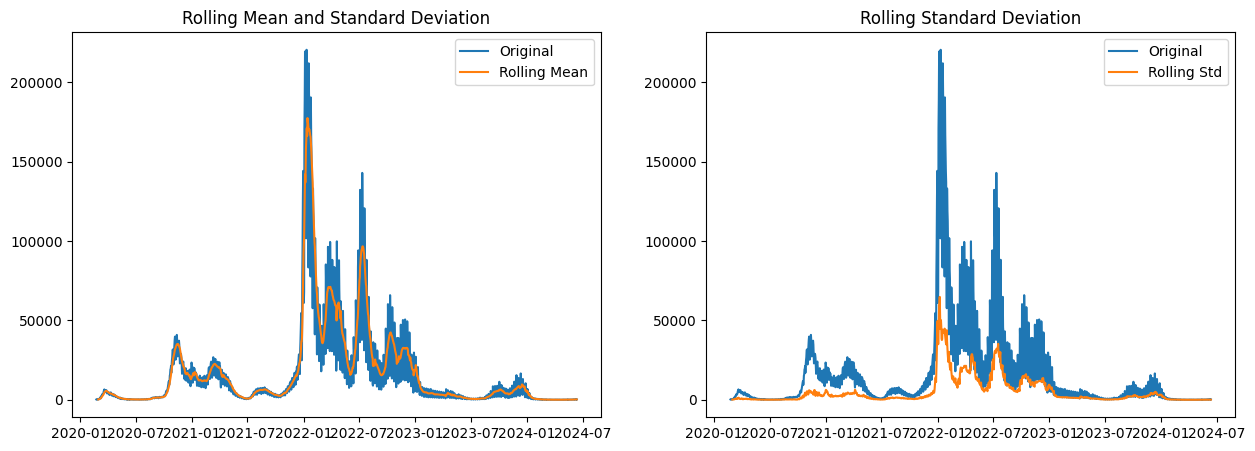

Results of Dickey-Fuller Test:
Test Statistic                   -3.854751
p-value                           0.002394
#Lags Used                       20.000000
Number of Observations Used    1550.000000
Critical Value (1%)              -3.434576
Critical Value (5%)              -2.863406
Critical Value (10%)             -2.567764
dtype: float64


In [22]:
# Test stationarity of the 'nuovi_positivi' column
test_stationarity(df_italy['nuovi_positivi'])

The function will display two plots: one showing the original time series along with the rolling mean, and another showing the original time series along with the rolling standard deviation. These plots can help visually identify trends, seasonality, or other patterns that indicate non-stationarity.
Additionally, the function will print the results of the Augmented Dickey-Fuller (ADF) test, which is a statistical test for stationarity. The null hypothesis of the ADF test is that the time series is non-stationary. If the p-value is less than a specified significance level (e.g., 0.05), we can reject the null hypothesis and conclude that the time series is stationary.
If the time series is found to be non-stationary, you can apply transformations like differencing or log transformation to make it stationary before fitting a time series forecasting model.

### Defining the prediction window


In [23]:
prediction_window = 28 #testing window (4 weeks of data)
forecast_window = 7 # forecasting window (1 week)
window = prediction_window + forecast_window #prediction + forecasting window

## The model: Prophet
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

We need two columns, Ds for the specific dates and y for the data

In [25]:
from prophet import Prophet


In [45]:
df_p = df['nuovi_positivi'].reset_index().copy()
df_p = df_p.rename(columns={'data': 'ds', 'nuovi_positivi': 'y'})
df_p = df_p.rename(columns={'index': 'ds', 'y': 'y'})

Chage the data type from numerical to date

In [61]:
df_p['ds'] = pd.to_datetime(df_p['ds'])
print(df_p.dtypes)

ds    datetime64[ns]
y              int64
dtype: object


#### Preprocess the data
We will check for null values and drop any rows with invalid dates


In [60]:
print(df_p[df_p['ds'].dt.day == 0])

Empty DataFrame
Columns: [ds, y]
Index: []


In [62]:
df_p = df_p[df_p['ds'].dt.day != 0]

## Build the Prophet Model
We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [64]:
prophet_model = Prophet(n_changepoints=50, # hyperparameter
                        seasonality_mode='multiplicative',
                       changepoint_prior_scale=10) # hyperparameter


In [65]:
prophet_model.add_seasonality('weekly', period = 7, fourier_order = 5)
prophet_model.add_seasonality('yearly', period = 365, fourier_order = 25)

In [66]:
prophet_model.add_country_holidays(country_name='Italy')

In [67]:
prophet_model.fit(df_p)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0lvvc43/6tw84uw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0lvvc43/7dx8srw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21600', 'data', 'file=/tmp/tmp_0lvvc43/6tw84uw6.json', 'init=/tmp/tmp_0lvvc43/7dx8srw4.json', 'output', 'file=/tmp/tmp_0lvvc43/prophet_modelom5ff1jf/prophet_model-20240617142647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done proc

######Data Forecasting
Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.



In [71]:
future = prophet_model.make_future_dataframe(periods=forecast_window)
future.tail()


,ds
32993,1970-01-04 00:00:00.000032990
32994,1970-01-05 00:00:00.000032990
32995,1970-01-06 00:00:00.000032990
32996,1970-01-07 00:00:00.000032990
32997,1970-01-08 00:00:00.000032990


The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [73]:
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
32993,1970-01-04 00:00:00.000032990,-6.339356e+12,-6.853746e+14,6.211204e+14
32994,1970-01-05 00:00:00.000032990,-6.737289e+12,-8.400246e+14,8.033744e+14
32995,1970-01-06 00:00:00.000032990,-5.770233e+12,-8.228652e+14,7.577136e+14
32996,1970-01-07 00:00:00.000032990,-3.717914e+12,-5.895667e+14,5.514819e+14
32997,1970-01-08 00:00:00.000032990,-6.006996e+12,-1.046486e+15,9.583896e+14


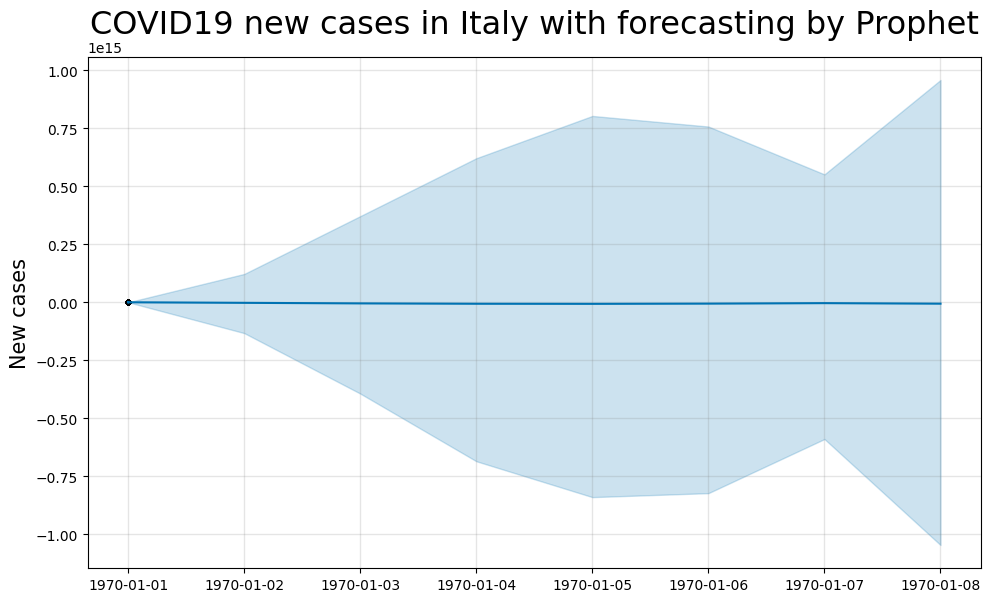

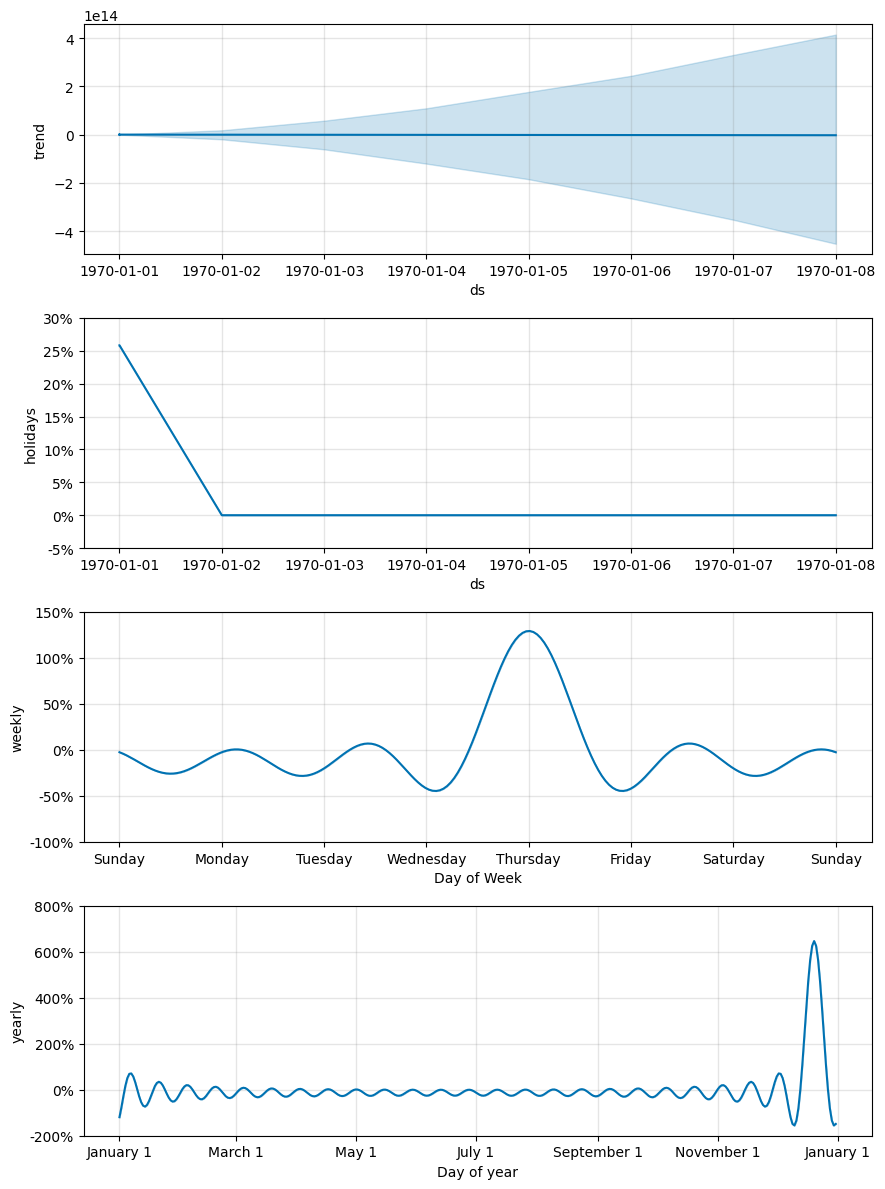

In [75]:
prophet_model.plot(forecast);
plt.title("COVID19 new cases in Italy with forecasting by Prophet", fontsize=23)
plt.ylabel("New cases", fontsize=15)
plt.xlabel('')
plt.show()

fig2 = prophet_model.plot_components(forecast)



Next, we want to make a custom plot to check the forecasted days. We first create a dataframe including the dates (ds), predicted values (yhat) and confidence intervals( yhat_lower and yhat_upper).